In [1]:
import torch
import torch.nn as nn
import copy
import math
from torch.nn.functional import log_softmax

RUN_EXAMPLES = True

In [2]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [3]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1)

In [4]:
def clones(module, N):
    "produce N identical layers"
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)

# Define Encoder
mask in forward function: mask out future positions. This means the model should not look ahead when predicting the next token in a sequence. This prevents information leakage from future tokens.

In [5]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)

        return self.norm(x)

# LayerNorm
Apply layer normalization. Not batch normalization!
[About Layer Normalization](https://arxiv.org/pdf/1607.06450)
self.a_2 and self.b_2 is learnable parameter

In [6]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)

        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

# Sublayer connection
The output of each sublayer is x + Sublayer(LayerNorm(x)), which has residual connection.

We also apply dropout to prevent over-fitting problem

In [7]:
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

# Encoder Layer
Encoder layer consist of two sublayers: Multi-head self-attention layer, and fully-connected feed-forward network

In [8]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))

        return self.sublayer[1](x, self.feed_forward)

# Decoder
Defining a decoder

In [9]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)

        return self.norm(x)

# Decoder Layer
Define Decoder Layer, 3 sublayers that is used in single decoder unit

For sublayer[0], apply self attention to output embedding

For sublayer[1], apply self attention to encoder output

In [10]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

# Subsequent Mask
Mask the future information. This blocks the information leakage of future token

torch.triu is triangular matrix
[[1, 1, 1, ..., 1]
 [0, 1, 1, ..., 1]
 [0, 0, 1, ..., 1]
 ...
 [0, 0, 0, ..., 1]]
 
 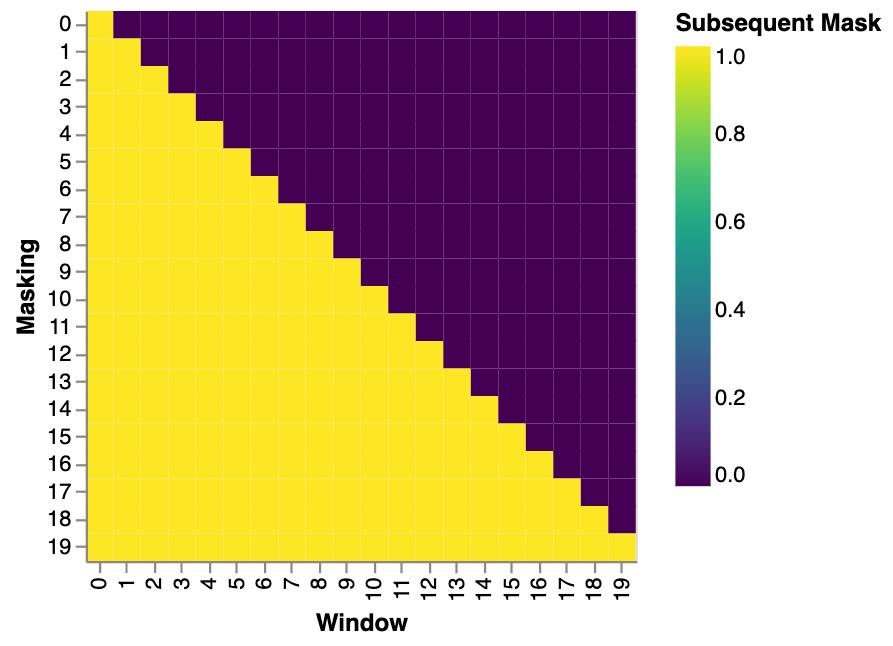

In [11]:
def subsequent_mask(size):
    attn_shape = (1, size, size)

    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
    return subsequent_mask == 0

# Attention
The core of the transformer model is attention mechanism
Attention(Query, Key, Value) = Attention_Weight(Query, Key) * Value

In our implementation, we are going to use dot-product attention for Attention_Weight

Query size: (1, d_k)

Key size: (d_model, d_k)

Value size: (d_model, 1)

In [12]:
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    p_attn = scores.softmax(dim=-1)

    if dropout is not None:
        p_attn = dropout(p_attn)

    return torch.matmul(p_attn, value), p_attn

# Multihead Attention
In real-world, we attend a sentence in various way. To apply this into attention method, we use mult-head attention.

We use multiple queries, keys, and values to extract the context from the sequence.

MultiHead(Q, K, V) = Concat(head_1, head_2, ..., head_h)W_o

where head_i = Attention(Q * W_i_Q, K * W_i_K, V * W_i_V)


We need 4 Linear layers.

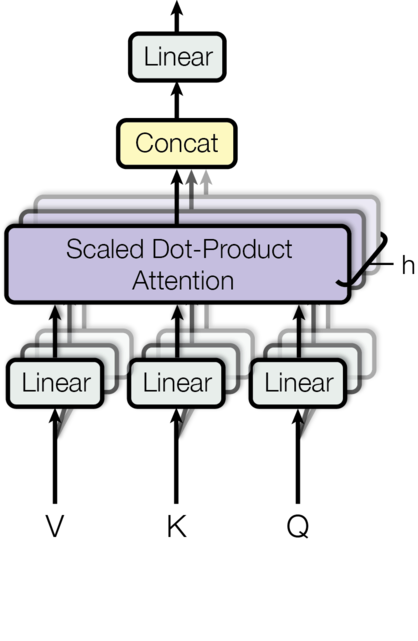

In [13]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # assume d_v is always equal to d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # Linear projections in batch from d_model -> h * d_k
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # Apply attention on all the projected vectors in batch
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

        # concat the attention outputs for each head
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)

        del query
        del key
        del value
        return self.linears[-1](x)

# Position-wise Feed-forward Network
Feedforward network consists of two linear transformation with ReLU.
FFN(x) = ReLU(W_1 * x + b_1) * W_2 + b_2

In [14]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

# Embedding and Softmax
For sequence transduction model, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension d_model.

We also use linear transformation and softmax to convert output vector of decoder into predicted next-token probabilities.

In [15]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

# Positional Encoding
Since we soley use self-attention(not CNN, RNN), we lose the position information.
To resolve this problem, we add positional information to the embedding vector. 

We use sine and cosine functions of different frequency.

In [16]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)

        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(1000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        # pe is not parameter
        # register as buffer
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

# Building final model

In [17]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)

    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab),
    )

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

# Dry run of the model

In [18]:
def inference_test():
    test_model = make_model(11, 11, 2)
    test_model.eval()

    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(9):
        out = test_model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]

        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )
    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()


show_example(run_tests)

Example Untrained Model Prediction: tensor([[0, 3, 5, 3, 5, 3, 4, 2, 5, 3]])
Example Untrained Model Prediction: tensor([[0, 8, 5, 2, 3, 9, 3, 9, 3, 9]])
Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 6, 1, 0]])
Example Untrained Model Prediction: tensor([[0, 1, 1, 1, 1, 1, 1, 3, 1, 3]])
Example Untrained Model Prediction: tensor([[0, 5, 4, 1, 1, 1, 1, 1, 1, 1]])
Example Untrained Model Prediction: tensor([[ 0,  6,  6, 10,  7,  7,  7,  7,  7,  7]])
Example Untrained Model Prediction: tensor([[0, 1, 7, 7, 7, 7, 1, 7, 1, 7]])
Example Untrained Model Prediction: tensor([[0, 2, 9, 9, 9, 3, 4, 0, 3, 4]])
Example Untrained Model Prediction: tensor([[ 0,  8,  2, 10,  8,  2, 10,  8,  2, 10]])
Example Untrained Model Prediction: tensor([[0, 7, 8, 8, 0, 7, 8, 0, 7, 8]])
